In [18]:
import numpy as np
np.random.seed(3407)

from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.circuit import CircBox
from pytket.circuit import QControlBox
from pytket.passes import DecomposeBoxes
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
phase_est_project = Nexus().new_project(f"Phase Estimation Tutorial - {datetime.now()}")

configuration = QuantinuumConfig(device_name="H1-1LE", user_group="iQuHACK_2024")
backend = NexusBackend(
    backend_config= configuration, 
    project= phase_est_project
)

# Quantum Phase Estimation: Evaluating Estimation Error of Variants of QPE

Our goal is to compare the error of the following Quantum Phase Estimation (QPE) algorithms:
1. Standard QPE algorithm
2. Iterative QPE
3. QPE with Efficient Bayesian Phase Estimation

We use the Quantinuum Nexus platform to implement and simulate each circuit and evaluate the measurement error while varying the following parameters:

- Number of qubits
- Number of shots to get the probability distribution of eigenvalues

## 1. Standard QPE Algorithm

We start off with the provided standard QPE algorithm and analyze the phase estimation error when estimating 1,000 phases sampled uniformly from $0 <= \theta <= 1$. For now, we use the $\text{U1}$ unitary gate and thus the $|1\rangle$ trivial eigenstate demonstrated in the handout code.

### 1.1 Hyperparameter Setup

For each of our evaluations (holding the number of qubits and shots constant), we want to sample the error of the quantum phase estimation algorithm along a variety of $\theta$'s.

In [7]:
n_theta = 1000
theta_list = list(np.random.random_sample((n_theta,)))
print("First 10 theta's: ", theta_list[:10])

First 10 theta's:  [0.25125502729360527, 0.07539824205113921, 0.891199920601043, 0.29837789148360383, 0.40461928329396124, 0.8735727727791519, 0.499776808427551, 0.9141236347239274, 0.548044630015203, 0.6933611941831399]


In [9]:
n_iter = 5 # repeat each experiment n_iter times
n_qubits_list = list(range(2, 10)) # number of qubits to test

### 1.2 Circuit Setup

Sourced from handout notebook.

In [21]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

def build_phase_estimation_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_qcontrolbox(
                controlled_u_gate, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    qpe_circ.add_circbox(inverse_qft_box, list(measurement_register))
    qpe_circ.measure_register(measurement_register, "c")

    DecomposeBoxes().apply(qpe_circ)
    
    return qpe_circ

def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 4,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [14]:
prep_circuit = Circuit(1).X(0)  # prepare the |1> eigenstate of U1

input_angle_example = 0.73

unitary_circuit = Circuit(1).U1(input_angle_example, 0)  # Base unitary for controlled U ops
qpe_circ_trivial = build_phase_estimation_circuit(
    4, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
)
render_circuit_jupyter(qpe_circ_trivial)

In [17]:
n_shots = 1000
compiled_circ = backend.get_compiled_circuit(qpe_circ_trivial)
result = backend.run_circuit(compiled_circ, n_shots)

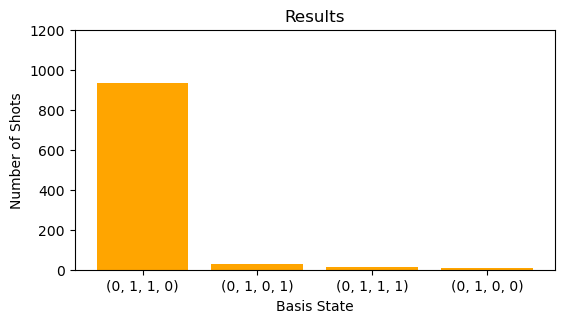

In [20]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))

In [26]:
theta = single_phase_from_backendresult(result)
error = round(abs(input_angle_example - (2 * theta)), 3)
print("theta =", theta, "with error", error)

theta = 0.375 with error 0.02


### 1.3 Experimental Harness

An experimental harness for, given an input angle, number of qubits, and number of shots, generate the error of the measurement.

In [ ]:
def run_qpe_experiment(input_angle: float, n_qubits: int, n_shots: int, show_circuit: bool = False, show_dist: bool = False):
    prep_circuit = Circuit(1).X(0)
    unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops
    qpe_circ_trivial = build_phase_estimation_circuit(
        n_qubits, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
    )

